In [1]:
import numpy as np
import torch
from systems import VanDerPol, PhaseSpace
from NFDiffeo import Diffeo
from Hutils import get_oscillator, cycle_error
from fit_SPE import fit_prototype
from matplotlib import pyplot as plt

In [2]:
def plot_invariant(H, a):
    """
    Plots the limit cycle of radius sqrt(a), through the diffeomorphism H
    """
    if a > 0:
        angles = torch.linspace(0, 2*np.pi, 200)

        true_rad = np.sqrt(a)
        true_pts = torch.stack([
            true_rad*torch.cos(angles),
            true_rad*torch.sin(angles),
        ]).T
        cycle = H.reverse(true_pts).detach().numpy()
        plt.plot(cycle[:, 0], cycle[:, 1], lw=3, color='red', alpha=.7, label='predicted')
    else:
        center = H.reverse(torch.zeros(1, 2)).detach().numpy()[0]
        plt.scatter(center[0], center[1], 90, 'red', alpha=.7, label='pred. cycle', marker='X')

def plot_trajectories(system: PhaseSpace, inits: torch.Tensor, T=30.):
    """
    Plot ground-truth trajectories from a system
    """
    traj = system.trajectories(inits, T=T, step=1e-3, euler=True).numpy()

    for i in range(traj.shape[1]):
        plt.plot(traj[:, i, 0], traj[:, i, 1], lw=3, color='k', alpha=.8, label='true trajectory' if i==0 else '')


100%|██████████| 2500/2500 [00:35<00:00, 70.59it/s, loss=0.0088]


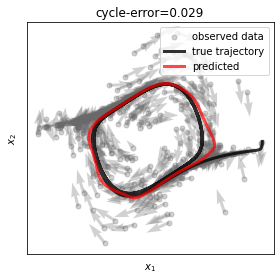

In [3]:
# hyperparameter settings
n_points = 500
its = 2500
lr = 1e-3
center_reg = .0
det_reg = .001
a, omega = .25, -.5
np.random.seed(0)
torch.manual_seed(0)

# load a Van der Pol system with a random limit cycle
system = VanDerPol(**VanDerPol.random_cycle_params())

# sample points from random trajectories of the system
x = system.rand_on_traj(system.random_x(n_points), T=3)
# calculate velocities
xdot = system(0, x)

# fit a diffeomorphism to the given data
H, loss, ldet, score = fit_prototype(
    H=Diffeo(dim=2, n_layers=4, K=4),
    x=x,
    xdot=xdot,
    g=get_oscillator(a=a, omega=omega),
    its=its,
    lr=lr,
    center_reg=center_reg,
    det_reg=det_reg,
    verbose=True,
    weight_decay=1e-3
)

# extract the ground truth cycle by simulating a long path and taking only the second half
cycle_traj = system.trajectories(x[:1], T=50)
cycle_traj = cycle_traj[cycle_traj.shape[0]//2:][:, 0]

# calculate the cycle error
err = cycle_error(H, cycle_traj, a)

plt.figure(figsize=(4, 4))

# plot vectors
norms = torch.clamp(torch.norm(xdot, dim=1, keepdim=True), 1)
dy = .5*xdot/norms
x, dy = x.detach().numpy(), dy.detach().numpy()
std = np.max(x)-np.min(x)
plt.scatter(x[:, 0], x[:, 1], 25, 'dimgray', alpha=.3, label='observed data')
plt.quiver(x[:, 0], x[:, 1], dy[:, 0], dy[:, 1], scale=5, color='dimgray', alpha=.3, width=.012)

# plot trajectories
ind = np.argmax(np.abs(x[:, 0]))
plot_trajectories(system, torch.from_numpy(x[ind:ind+1]), T=30)
plot_invariant(H, a)

plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend(loc='upper right')
plt.title(f"cycle-error={err:.3f}")
plt.tight_layout()
plt.show()